In [2]:
import argparse
import numpy as np
import mxnet as mx
import data_loader as dl
import module
import os
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from mxnet.gluon.data import vision
from multiprocessing import cpu_count
mx.random.seed(42)
import matplotlib.pyplot as plt

#os.listdir()

In [3]:
def transform(data, label):
    data = data.astype('float32')/255
    return data, label

def shuffle_dataset(X,Y):
    
    '''
        Write code to shuffle the dataset here. 
        
        Args: 
            X: Input feature ndarray
            Y: Input values ndarray
            
        Return:
            X and Y shuffled in place
    
    '''
    r = np.arange(len(X))
    np.random.shuffle(r)
    X = X[r]
    Y = Y[r]
    return (X,Y)
    pass

class DataIterLoader():
    def __init__(self, data_iter):
        self.data_iter = data_iter

    def __iter__(self):
        self.data_iter.reset()
        return self

    def __next__(self):
        batch = self.data_iter.__next__()
        assert len(batch.data) == len(batch.label) == 1
        data = batch.data[0]
        label = batch.label[0]
        return data, label
    


# Input Data

In [4]:
(train_images,train_labels)=dl.DataLoader().load_data('train')
(test_images,test_labels)=dl.DataLoader().load_data('test')
batch_size=32

ntrain=int(0.7*len(train_images))
train_iter = mx.io.NDArrayIter(train_images[:ntrain, :]/255, train_labels[:ntrain], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(train_images[ntrain:, :]/255, train_labels[ntrain:], batch_size)
test_iter = mx.io.NDArrayIter(test_images/255, test_labels, batch_size)

train_loader = DataIterLoader(train_iter)
val_loader = DataIterLoader(val_iter)
test_loader = DataIterLoader(test_iter)

# Defining Neural Network

In [5]:
net2 = nn.HybridSequential()

with net2.name_scope():
    net2.add(
        #nn.Dropout(.5)
        #nn.Flatten(),
        #nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(1024, activation='relu'),
        #nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(512, activation='relu'),
        #nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(256, activation='relu'),
        #nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(10, activation=None)  # loss function includes softmax already, see below
    )
net2.hybridize()

In [6]:
def neural_net_training(net,trainer,ctx):
    epochs = 10
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    epoch_history = []
    for epoch in range(epochs):
        # training loop (with autograd and trainer steps, etc.)
        cumulative_train_loss = mx.nd.zeros(1, ctx=ctx)
        training_samples = 0
        for batch_idx, (data, label) in enumerate(train_loader):
            data = data.as_in_context(ctx).reshape((-1, 784)) # 28*28=784
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = loss_function(output, label)
            loss.backward()
            metric.update(label, output)
            trainer.step(data.shape[0])
            cumulative_train_loss += loss.sum()
            training_samples += data.shape[0]


        train_loss = cumulative_train_loss.asscalar()/training_samples
        train_name, train_acc = metric.get()
        #print('After epoch {}: {} = {}'.format(epoch + 1, name, acc))
        metric.reset()

        # validation loop
        cumulative_val_loss = mx.nd.zeros(1, ctx)
        val_samples = 0
        for batch_idx, (data, label) in enumerate(val_loader):
            data = data.as_in_context(ctx).reshape((-1, 784)) # 28*28=784
            label = label.as_in_context(ctx)
            output = net(data)
            loss = loss_function(output, label)
            cumulative_val_loss += loss.sum()
            val_samples += data.shape[0]
            metric.update(label, output)
        val_loss = cumulative_val_loss.asscalar()/val_samples
        val_name, val_acc = metric.get()
        metric.reset()

        print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}".format(epoch, train_loss, val_loss))
        print("training accuracy: {}, validation accuracy: {}".format(train_acc,val_acc))
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        epoch_history.append(epoch+1)
#     plt.plot(epoch_history, train_loss_history, epoch_history, val_loss_history )
#     plt.title('Loss')
#     plt.show()

#     plt.plot(epoch_history, train_acc_history, epoch_history, val_acc_history )
#     plt.title('Accuracy')
#     plt.show()
    return epoch_history,train_loss_history,val_loss_history,train_acc_history,val_acc_history

    pass

In [7]:
def neural_net_testing(net,ctx):
    cumulative_test_loss = mx.nd.zeros(1, ctx)
    test_samples = 0
    for batch_idx, (data, label) in enumerate(test_loader):
            data = data.as_in_context(ctx).reshape((-1, 784)) # 28*28=784
            label = label.as_in_context(ctx)
            output = net(data)
            loss = loss_function(output, label)
            cumulative_test_loss += loss.sum()
            test_samples += data.shape[0]
            metric.update(label, output)
    test_loss = cumulative_test_loss.asscalar()/test_samples
    test_name, test_acc = metric.get()
    print("Final testing loss: {:.2f}".format(test_loss))
    print("testing accuracy: {}".format(test_acc))
    pass

## Xavier Initialization

Epoch 0, training loss: 0.58, validation loss: 0.43
training accuracy: 0.7960538842345773, validation accuracy: 0.8412522202486679
Epoch 1, training loss: 0.40, validation loss: 0.38
training accuracy: 0.8532463823305407, validation accuracy: 0.8601243339253997
Epoch 2, training loss: 0.35, validation loss: 0.35
training accuracy: 0.8690974866717441, validation accuracy: 0.8697269094138543
Epoch 3, training loss: 0.32, validation loss: 0.34
training accuracy: 0.8798552932216298, validation accuracy: 0.8732793072824157
Epoch 4, training loss: 0.30, validation loss: 0.34
training accuracy: 0.8881378522467631, validation accuracy: 0.8756105683836589
Epoch 5, training loss: 0.28, validation loss: 0.34
training accuracy: 0.8953493907083016, validation accuracy: 0.8773867673179396
Epoch 6, training loss: 0.26, validation loss: 0.33
training accuracy: 0.9024895277989338, validation accuracy: 0.8793849911190054
Epoch 7, training loss: 0.25, validation loss: 0.33
training accuracy: 0.9082492383

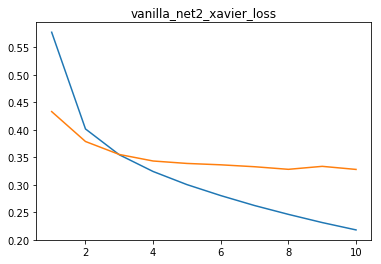

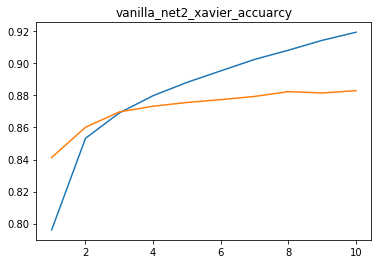

In [8]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Xavier(),ctx=ctx,force_reinit=True)

trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_xavier,val_loss_history_xavier,train_acc_history_xavier,val_acc_history_xavier = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

filename='vanilla_net2_xavier.params'
net2.save_parameters(filename)
plt.plot(epoch_history, train_loss_history_xavier, epoch_history, val_loss_history_xavier )
plt.title('vanilla_net2_xavier_loss')
plt.savefig('vanilla_net2_xavier_loss.png')
plt.show()

plt.plot(epoch_history, train_acc_history_xavier, epoch_history, val_acc_history_xavier )
plt.title('vanilla_net2_xavier_accuarcy')
plt.savefig('vanilla_net2_xavier_accuarcy.png')
plt.show()


## Normal Initialization

Epoch 0, training loss: 1.67, validation loss: 0.85
training accuracy: 0.36117193450114243, validation accuracy: 0.6601909413854352
Epoch 1, training loss: 0.75, validation loss: 0.65
training accuracy: 0.724747715156131, validation accuracy: 0.7504440497335702
Epoch 2, training loss: 0.55, validation loss: 0.51
training accuracy: 0.7971725057121096, validation accuracy: 0.8216585257548845
Epoch 3, training loss: 0.46, validation loss: 0.45
training accuracy: 0.8350628332063975, validation accuracy: 0.8422513321492007
Epoch 4, training loss: 0.41, validation loss: 0.41
training accuracy: 0.8511281416603199, validation accuracy: 0.8534635879218473
Epoch 5, training loss: 0.38, validation loss: 0.39
training accuracy: 0.8634805788271135, validation accuracy: 0.8598468028419183
Epoch 6, training loss: 0.35, validation loss: 0.39
training accuracy: 0.8720725437928408, validation accuracy: 0.8633436944937833
Epoch 7, training loss: 0.33, validation loss: 0.38
training accuracy: 0.8788794744

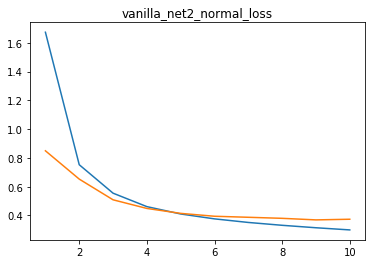

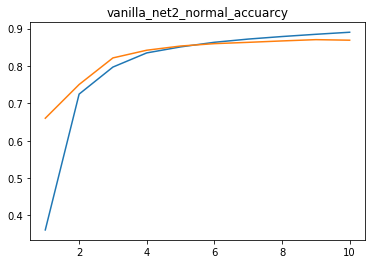

In [9]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_normal,val_loss_history_normal,train_acc_history_normal,val_acc_history_normal = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

filename='vanilla_net2_normal.params'
net2.save_parameters(filename)
plt.plot(epoch_history, train_loss_history_normal, epoch_history, val_loss_history_normal)
plt.title('vanilla_net2_normal_loss')
plt.savefig('vanilla_net2_normal_loss.png')
plt.show()

plt.plot(epoch_history, train_acc_history_normal, epoch_history, val_acc_history_normal )
plt.title('vanilla_net2_normal_accuarcy')
plt.savefig('vanilla_net2_normal_accuarcy.png')
plt.show()


## Orthogonal Initialization

Epoch 0, training loss: 0.55, validation loss: 0.42
training accuracy: 0.8060500761614623, validation accuracy: 0.8452486678507993
Epoch 1, training loss: 0.39, validation loss: 0.37
training accuracy: 0.8591250952018279, validation accuracy: 0.8619005328596803
Epoch 2, training loss: 0.34, validation loss: 0.36
training accuracy: 0.8748571972581873, validation accuracy: 0.8687277975133215
Epoch 3, training loss: 0.31, validation loss: 0.35
training accuracy: 0.8856626047220106, validation accuracy: 0.8706150088809946
Epoch 4, training loss: 0.29, validation loss: 0.35
training accuracy: 0.894563975628332, validation accuracy: 0.8733348134991119
Epoch 5, training loss: 0.26, validation loss: 0.35
training accuracy: 0.902251523229246, validation accuracy: 0.8746114564831261
Epoch 6, training loss: 0.24, validation loss: 0.34
training accuracy: 0.9106292840822544, validation accuracy: 0.8759436056838366
Epoch 7, training loss: 0.23, validation loss: 0.34
training accuracy: 0.917293412033

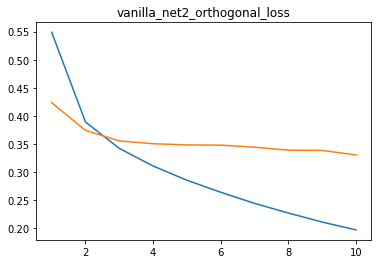

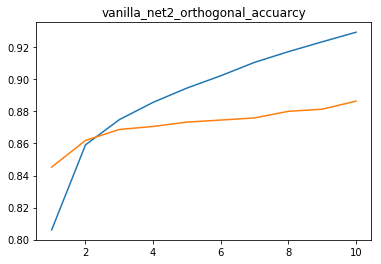

In [10]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Orthogonal(),ctx=ctx,force_reinit=True)

trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_orthogonal,val_loss_history_orthogonal,train_acc_history_orthogonal,val_acc_history_orthogonal = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

filename='vanilla_net2_orthogonal.params'
net2.save_parameters(filename)
plt.plot(epoch_history, train_loss_history_orthogonal, epoch_history, val_loss_history_orthogonal)
plt.title('vanilla_net2_orthogonal_loss')
plt.savefig('vanilla_net2_orthogonal_loss.png')
plt.show()

plt.plot(epoch_history, train_acc_history_orthogonal, epoch_history, val_acc_history_orthogonal )
plt.title('vanilla_net2_orthogonal_accuarcy')
plt.savefig('vanilla_net2_orthogonal_accuarcy.png')
plt.show()


## Experiment 1 Plots

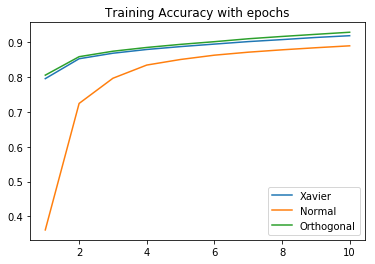

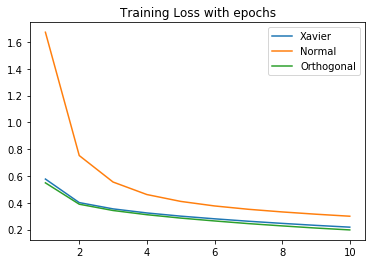

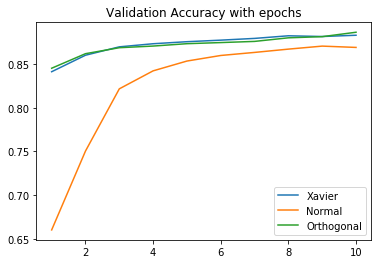

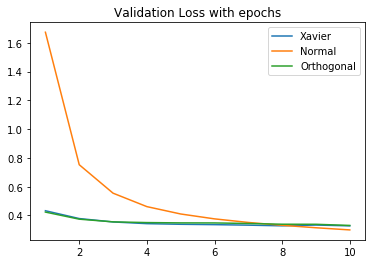

In [15]:
plt.plot(epoch_history, train_acc_history_xavier)
plt.plot(epoch_history, train_acc_history_normal)
plt.plot(epoch_history, train_acc_history_orthogonal)
plt.title('Training Accuracy with epochs')
plt.legend(('Xavier','Normal','Orthogonal'))
plt.savefig('exp1_training_acc.png')
plt.show()

plt.plot(epoch_history, train_loss_history_xavier)
plt.plot(epoch_history, train_loss_history_normal)
plt.plot(epoch_history, train_loss_history_orthogonal)
plt.title('Training Loss with epochs')
plt.legend(('Xavier','Normal','Orthogonal'))
plt.savefig('exp1_training_loss.png')
plt.show()

plt.plot(epoch_history, val_acc_history_xavier)
plt.plot(epoch_history, val_acc_history_normal)
plt.plot(epoch_history, val_acc_history_orthogonal)
plt.title('Validation Accuracy with epochs')
plt.legend(('Xavier','Normal','Orthogonal'))
plt.savefig('exp1_validation_acc.png')
plt.show()

plt.plot(epoch_history, val_loss_history_xavier)
plt.plot(epoch_history, train_loss_history_normal)
plt.plot(epoch_history, val_loss_history_orthogonal)
plt.title('Validation Loss with epochs')
plt.legend(('Xavier','Normal','Orthogonal'))
plt.savefig('exp1_validation_loss.png')
plt.show()



## Exp2 Batch Normalization 

In [16]:
net2 = nn.HybridSequential()

with net2.name_scope():
    net2.add(
        #nn.Dropout(.5)
        #nn.Flatten(),
        nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(1024, activation='relu'),
        nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(512, activation='relu'),
        nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(256, activation='relu'),
        nn.BatchNorm(axis=1, center=True, scale=True),
        nn.Dense(10, activation=None)  # loss function includes softmax already, see below
    )
net2.hybridize()

Epoch 0, training loss: 0.51, validation loss: 0.37
training accuracy: 0.8183311119573495, validation accuracy: 0.8625666074600356
Epoch 1, training loss: 0.36, validation loss: 0.35
training accuracy: 0.870049504950495, validation accuracy: 0.8743894316163411
Epoch 2, training loss: 0.29, validation loss: 0.35
training accuracy: 0.8927075399847677, validation accuracy: 0.8774422735346359
Epoch 3, training loss: 0.24, validation loss: 0.38
training accuracy: 0.911200495049505, validation accuracy: 0.8748889875666075
Epoch 4, training loss: 0.20, validation loss: 0.39
training accuracy: 0.9254093678598629, validation accuracy: 0.8772757548845471
Epoch 5, training loss: 0.17, validation loss: 0.43
training accuracy: 0.9367859862909368, validation accuracy: 0.8727797513321492
Epoch 6, training loss: 0.15, validation loss: 0.46
training accuracy: 0.9452113480578828, validation accuracy: 0.8726687388987566
Epoch 7, training loss: 0.13, validation loss: 0.49
training accuracy: 0.954017517136

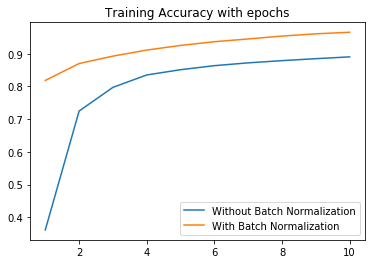

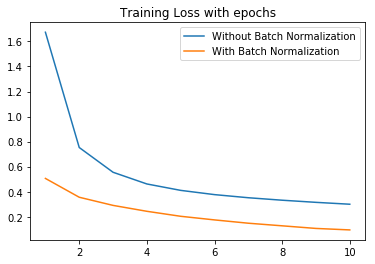

In [17]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_batch_normal,val_loss_history_batch_normal,train_acc_history_batch_normal,val_acc_history_batch_normal = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

filename='vanilla_net2_batch_normal.params'
net2.save_parameters(filename)

plt.plot(epoch_history, train_acc_history_normal)
plt.plot(epoch_history, train_acc_history_batch_normal)
plt.title('Training Accuracy with epochs')
plt.legend(('Without Batch Normalization','With Batch Normalization'))
plt.savefig('exp2_training_acc.png')
plt.show()

plt.plot(epoch_history, train_loss_history_normal)
plt.plot(epoch_history, train_loss_history_batch_normal)
plt.title('Training Loss with epochs')
plt.legend(('Without Batch Normalization','With Batch Normalization'))
plt.savefig('exp2_training_loss.png')
plt.show()

## Exp3 Dropout Comparison

In [19]:
x = 0.6 #Dropout rate
net3 = nn.HybridSequential()

with net3.name_scope():
    net3.add(
        nn.Flatten(),
        nn.Dense(1024, activation='relu'),
        nn.Dropout(x),
        nn.Dense(512, activation='relu'),
        nn.Dropout(x),
        nn.Dense(256, activation='relu'),
        nn.Dropout(x),
        nn.Dense(10, activation=None)  # loss function includes softmax already, see below
    )
net3.hybridize()

ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net3.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer3 = gluon.Trainer(
    params=net3.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_dropout_06,val_loss_history_dropout_06,train_acc_history_dropout_06,val_acc_history_dropout_06 = neural_net_training(net3,trainer3,ctx)
neural_net_testing(net3,ctx)

filename='vanilla_net3_dropout_0.6_.params'
net3.save_parameters(filename)


Epoch 0, training loss: 1.91, validation loss: 1.02
training accuracy: 0.26013899466869767, validation accuracy: 0.5612233570159858
Epoch 1, training loss: 0.90, validation loss: 0.65
training accuracy: 0.6460634044173648, validation accuracy: 0.76398756660746
Epoch 2, training loss: 0.67, validation loss: 0.54
training accuracy: 0.7540698781416603, validation accuracy: 0.8070048845470693
Epoch 3, training loss: 0.58, validation loss: 0.48
training accuracy: 0.7858672886519421, validation accuracy: 0.8243783303730018
Epoch 4, training loss: 0.53, validation loss: 0.43
training accuracy: 0.8082159177456207, validation accuracy: 0.841696269982238
Epoch 5, training loss: 0.50, validation loss: 0.42
training accuracy: 0.8212109672505712, validation accuracy: 0.8449711367673179
Epoch 6, training loss: 0.47, validation loss: 0.40
training accuracy: 0.8310167555217061, validation accuracy: 0.8514653641207816
Epoch 7, training loss: 0.45, validation loss: 0.39
training accuracy: 0.837181073876

In [20]:
x = 0.4 #Dropout rate
net3 = nn.HybridSequential()

with net3.name_scope():
    net3.add(
        nn.Flatten(),
        nn.Dense(1024, activation='relu'),
        nn.Dropout(x),
        nn.Dense(512, activation='relu'),
        nn.Dropout(x),
        nn.Dense(256, activation='relu'),
        nn.Dropout(x),
        nn.Dense(10, activation=None)  # loss function includes softmax already, see below
    )
net3.hybridize()

ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net3.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer3 = gluon.Trainer(
    params=net3.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_dropout_04,val_loss_history_dropout_04,train_acc_history_dropout_04,val_acc_history_dropout_04 = neural_net_training(net3,trainer3,ctx)
neural_net_testing(net3,ctx)

filename='vanilla_net3_dropout_0.4_.params'
net3.save_parameters(filename)


Epoch 0, training loss: 1.83, validation loss: 0.97
training accuracy: 0.292721820258949, validation accuracy: 0.6034635879218473
Epoch 1, training loss: 0.83, validation loss: 0.63
training accuracy: 0.6880712109672505, validation accuracy: 0.7658747779751333
Epoch 2, training loss: 0.60, validation loss: 0.50
training accuracy: 0.7828684310738766, validation accuracy: 0.8247113676731794
Epoch 3, training loss: 0.51, validation loss: 0.44
training accuracy: 0.8177361005331303, validation accuracy: 0.8438610124333925
Epoch 4, training loss: 0.46, validation loss: 0.41
training accuracy: 0.8359196496572734, validation accuracy: 0.8501887211367674
Epoch 5, training loss: 0.43, validation loss: 0.39
training accuracy: 0.8460586443259711, validation accuracy: 0.8547957371225577
Epoch 6, training loss: 0.41, validation loss: 0.39
training accuracy: 0.8529369763899467, validation accuracy: 0.8582926287744227
Epoch 7, training loss: 0.39, validation loss: 0.36
training accuracy: 0.85684025133

In [21]:
x = 0.1 #Dropout rate
net3 = nn.HybridSequential()

with net3.name_scope():
    net3.add(
        nn.Flatten(),
        nn.Dense(1024, activation='relu'),
        nn.Dropout(x),
        nn.Dense(512, activation='relu'),
        nn.Dropout(x),
        nn.Dense(256, activation='relu'),
        nn.Dropout(x),
        nn.Dense(10, activation=None)  # loss function includes softmax already, see below
    )
net3.hybridize()

ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net3.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer3 = gluon.Trainer(
    params=net3.collect_params(),
    optimizer='sgd',
    optimizer_params={'learning_rate': 0.04},
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_dropout_01,val_loss_history_dropout_01,train_acc_history_dropout_01,val_acc_history_dropout_01 = neural_net_training(net3,trainer3,ctx)
neural_net_testing(net3,ctx)

filename='vanilla_net3_dropout_0.1_.params'
net3.save_parameters(filename)



Epoch 0, training loss: 1.68, validation loss: 0.85
training accuracy: 0.3704303122619954, validation accuracy: 0.6598023978685613
Epoch 1, training loss: 0.75, validation loss: 0.60
training accuracy: 0.7230102817974106, validation accuracy: 0.7883547957371225
Epoch 2, training loss: 0.54, validation loss: 0.49
training accuracy: 0.8042650418888042, validation accuracy: 0.8267095914742452
Epoch 3, training loss: 0.47, validation loss: 0.44
training accuracy: 0.8333253998476771, validation accuracy: 0.8423068383658969
Epoch 4, training loss: 0.42, validation loss: 0.41
training accuracy: 0.8486528941355674, validation accuracy: 0.8534635879218473
Epoch 5, training loss: 0.39, validation loss: 0.38
training accuracy: 0.8597677075399848, validation accuracy: 0.8640652753108348
Epoch 6, training loss: 0.36, validation loss: 0.37
training accuracy: 0.8683358720487433, validation accuracy: 0.8664520426287744
Epoch 7, training loss: 0.34, validation loss: 0.36
training accuracy: 0.8746429931

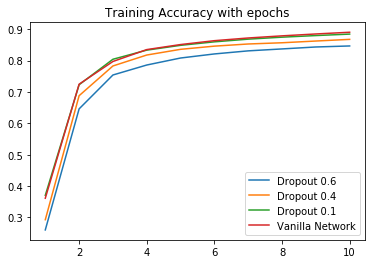

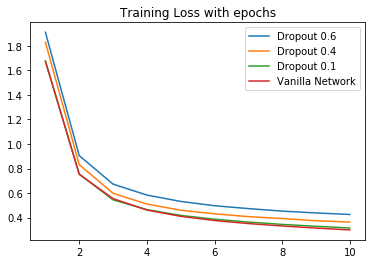

In [22]:
plt.plot(epoch_history, train_acc_history_dropout_06)
plt.plot(epoch_history, train_acc_history_dropout_04)
plt.plot(epoch_history, train_acc_history_dropout_01)
plt.plot(epoch_history, train_acc_history_normal)
plt.title('Training Accuracy with epochs')
plt.legend(('Dropout 0.6','Dropout 0.4','Dropout 0.1','Vanilla Network'))
plt.savefig('exp3_training_acc.png')
plt.show()

plt.plot(epoch_history, train_loss_history_dropout_06)
plt.plot(epoch_history, train_loss_history_dropout_04)
plt.plot(epoch_history, train_loss_history_dropout_01)
plt.plot(epoch_history, train_loss_history_normal)
plt.title('Training Loss with epochs')
plt.legend(('Dropout 0.6','Dropout 0.4','Dropout 0.1','Vanilla Network'))
plt.savefig('exp3_training_loss.png')
plt.show()

## Exp 4: Optimizer comparison

## SGD Optimizer

In [23]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='sgd',
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_sgd,val_loss_history_sgd,train_acc_history_sgd,val_acc_history_sgd = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

filename='vanilla_net2_sgd.params'
net2.save_parameters(filename)



Epoch 0, training loss: 0.49, validation loss: 0.37
training accuracy: 0.8293745239908606, validation accuracy: 0.8701154529307282
Epoch 1, training loss: 0.33, validation loss: 0.36
training accuracy: 0.8809501142421935, validation accuracy: 0.8738898756660746
Epoch 2, training loss: 0.26, validation loss: 0.37
training accuracy: 0.9079874333587205, validation accuracy: 0.8745559502664298
Epoch 3, training loss: 0.20, validation loss: 0.39
training accuracy: 0.9290984386900228, validation accuracy: 0.8725577264653641
Epoch 4, training loss: 0.16, validation loss: 0.41
training accuracy: 0.9451399466869764, validation accuracy: 0.8719471580817052
Epoch 5, training loss: 0.12, validation loss: 0.43
training accuracy: 0.9584444021325209, validation accuracy: 0.8765541740674956
Epoch 6, training loss: 0.11, validation loss: 0.45
training accuracy: 0.9645135186595583, validation accuracy: 0.8721691829484902
Epoch 7, training loss: 0.09, validation loss: 0.48
training accuracy: 0.9694878141

## Adam Optimizer 

In [24]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='adam',
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_adam,val_loss_history_adam,train_acc_history_adam,val_acc_history_adam = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

filename='vanilla_net2_adam.params'
net2.save_parameters(filename)


Epoch 0, training loss: 0.53, validation loss: 0.41
training accuracy: 0.8115717821782178, validation accuracy: 0.8535190941385435
Epoch 1, training loss: 0.39, validation loss: 0.39
training accuracy: 0.8572686595582635, validation accuracy: 0.8617895204262878
Epoch 2, training loss: 0.33, validation loss: 0.38
training accuracy: 0.8783082635186595, validation accuracy: 0.8665630550621669
Epoch 3, training loss: 0.29, validation loss: 0.37
training accuracy: 0.8935881568926123, validation accuracy: 0.8727242451154529
Epoch 4, training loss: 0.26, validation loss: 0.38
training accuracy: 0.9069640137090632, validation accuracy: 0.8775532859680284
Epoch 5, training loss: 0.23, validation loss: 1.08
training accuracy: 0.9166984006092918, validation accuracy: 0.8745004440497336
Epoch 6, training loss: 0.20, validation loss: 1.25
training accuracy: 0.925195163747144, validation accuracy: 0.8741119005328597
Epoch 7, training loss: 0.17, validation loss: 1.13
training accuracy: 0.93650038080

## AdaDelta

In [27]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='AdaDelta',
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_AdaDelta,val_loss_history_AdaDelta,train_acc_history_AdaDelta,val_acc_history_AdaDelta = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

filename='vanilla_net2_AdaDelta.params'
net2.save_parameters(filename)


Epoch 0, training loss: 0.60, validation loss: 0.40
training accuracy: 0.7917936024371668, validation accuracy: 0.8549622557726465
Epoch 1, training loss: 0.41, validation loss: 0.37
training accuracy: 0.8533653846153846, validation accuracy: 0.8703374777975134
Epoch 2, training loss: 0.35, validation loss: 0.36
training accuracy: 0.8738813785224676, validation accuracy: 0.874167406749556
Epoch 3, training loss: 0.30, validation loss: 0.37
training accuracy: 0.8900180883472962, validation accuracy: 0.8759436056838366
Epoch 4, training loss: 0.27, validation loss: 0.39
training accuracy: 0.902989337395278, validation accuracy: 0.8772757548845471
Epoch 5, training loss: 0.24, validation loss: 0.40
training accuracy: 0.9126047220106626, validation accuracy: 0.8748889875666075
Epoch 6, training loss: 0.22, validation loss: 0.46
training accuracy: 0.9201732673267327, validation accuracy: 0.8693938721136767
Epoch 7, training loss: 0.20, validation loss: 0.46
training accuracy: 0.928170220868

## AdaGrad 

In [26]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='AdaGrad',
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_AdaGrad,val_loss_history_AdaGrad,train_acc_history_AdaGrad,val_acc_history_AdaGrad = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

filename='vanilla_net2_AdaGrad.params'
net2.save_parameters(filename)


Epoch 0, training loss: 0.51, validation loss: 0.37
training accuracy: 0.8166650799695354, validation accuracy: 0.8671736234458259
Epoch 1, training loss: 0.35, validation loss: 0.34
training accuracy: 0.8745477913175933, validation accuracy: 0.8772202486678508
Epoch 2, training loss: 0.29, validation loss: 0.33
training accuracy: 0.8963252094440213, validation accuracy: 0.8822713143872114
Epoch 3, training loss: 0.24, validation loss: 0.34
training accuracy: 0.9145087585681645, validation accuracy: 0.8843805506216696
Epoch 4, training loss: 0.20, validation loss: 0.36
training accuracy: 0.9307882711348058, validation accuracy: 0.883214920071048
Epoch 5, training loss: 0.16, validation loss: 0.37
training accuracy: 0.9462585681645087, validation accuracy: 0.8843805506216696
Epoch 6, training loss: 0.12, validation loss: 0.41
training accuracy: 0.959801028179741, validation accuracy: 0.8828818827708703
Epoch 7, training loss: 0.09, validation loss: 0.45
training accuracy: 0.973652894135

## RMSProp 

In [28]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='RMSProp',
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_RMSProp,val_loss_history_RMSProp,train_acc_history_RMSProp,val_acc_history_RMSProp = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

filename='vanilla_net2_RMSProp.params'
net2.save_parameters(filename)



Epoch 0, training loss: 0.55, validation loss: 0.39
training accuracy: 0.8059072734196496, validation accuracy: 0.8594027531083481
Epoch 1, training loss: 0.39, validation loss: 0.36
training accuracy: 0.8593630997715156, validation accuracy: 0.8715586145648313
Epoch 2, training loss: 0.33, validation loss: 0.36
training accuracy: 0.8814023229246002, validation accuracy: 0.8772202486678508
Epoch 3, training loss: 0.28, validation loss: 0.39
training accuracy: 0.8992050647372429, validation accuracy: 0.8760546181172292
Epoch 4, training loss: 0.25, validation loss: 0.40
training accuracy: 0.9124143183549124, validation accuracy: 0.8765541740674956
Epoch 5, training loss: 0.21, validation loss: 0.42
training accuracy: 0.9248143564356436, validation accuracy: 0.8790519538188277
Epoch 6, training loss: 0.18, validation loss: 0.46
training accuracy: 0.9354055597867479, validation accuracy: 0.8767206927175843
Epoch 7, training loss: 0.16, validation loss: 0.51
training accuracy: 0.9438071210

## Nesterov accelerated SGD

In [29]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

net2.initialize(mx.init.Normal(),ctx=ctx,force_reinit=True)

trainer2 = gluon.Trainer(
    params=net2.collect_params(),
    optimizer='NAG',
)

# optimizer_paramsSoftmaxCrossEntropyLoss combines the softmax activation and the cross entropy loss 
# function in one layer, therefore the last layer in our network has no activation function.

metric = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
epoch_history,train_loss_history_NAG,val_loss_history_NAG,train_acc_history_NAG,val_acc_history_NAG = neural_net_training(net2,trainer2,ctx)
neural_net_testing(net2,ctx)

filename='vanilla_net2_NAG.params'
net2.save_parameters(filename)


Epoch 0, training loss: 0.50, validation loss: 0.36
training accuracy: 0.8290889185072353, validation accuracy: 0.8716141207815276
Epoch 1, training loss: 0.33, validation loss: 0.35
training accuracy: 0.8808549124143183, validation accuracy: 0.8756660746003553
Epoch 2, training loss: 0.26, validation loss: 0.35
training accuracy: 0.9076542269611576, validation accuracy: 0.8793849911190054
Epoch 3, training loss: 0.20, validation loss: 0.36
training accuracy: 0.9290270373191165, validation accuracy: 0.8796625222024866
Epoch 4, training loss: 0.16, validation loss: 0.40
training accuracy: 0.9458777608530083, validation accuracy: 0.8731682948490231
Epoch 5, training loss: 0.12, validation loss: 0.43
training accuracy: 0.9588252094440213, validation accuracy: 0.8741119005328597
Epoch 6, training loss: 0.10, validation loss: 0.44
training accuracy: 0.9653703351104341, validation accuracy: 0.8754995559502664
Epoch 7, training loss: 0.09, validation loss: 0.45
training accuracy: 0.9687738004

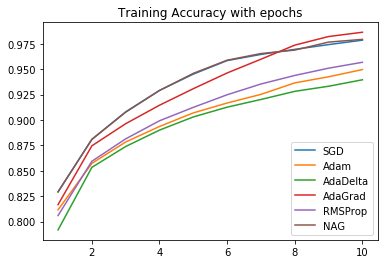

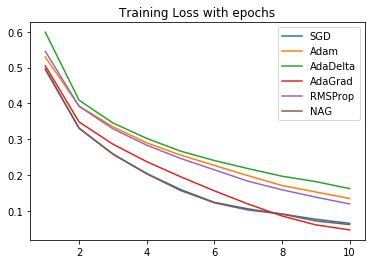

In [30]:
plt.plot(epoch_history, train_acc_history_sgd)
plt.plot(epoch_history, train_acc_history_adam)
plt.plot(epoch_history, train_acc_history_AdaDelta)
plt.plot(epoch_history, train_acc_history_AdaGrad)
plt.plot(epoch_history, train_acc_history_RMSProp)
plt.plot(epoch_history, train_acc_history_NAG)
plt.title('Training Accuracy with epochs')
plt.legend(('SGD','Adam','AdaDelta','AdaGrad','RMSProp','NAG'))
plt.savefig('exp4_training_acc.png')
plt.show()

plt.plot(epoch_history, train_loss_history_sgd)
plt.plot(epoch_history, train_loss_history_adam)
plt.plot(epoch_history, train_loss_history_AdaDelta)
plt.plot(epoch_history, train_loss_history_AdaGrad)
plt.plot(epoch_history, train_loss_history_RMSProp)
plt.plot(epoch_history, train_loss_history_NAG)
plt.title('Training Loss with epochs')
plt.legend(('SGD','Adam','AdaDelta','AdaGrad','RMSProp','NAG'))
plt.savefig('exp4_training_loss.png')
plt.show()